# Notebook 2d : Transformer avec Spike Dropout + Gaussian Noise (data augmentation)

## Modifications par rapport au notebook 02

1. **Spike dropout (15%)** : pendant le training, on masque aléatoirement 15% des spikes de chaque séquence. Force le modèle à exploiter des patterns redondants dans la population neuronale.

2. **Gaussian noise sur les waveforms** : pendant le training, on ajoute du bruit N(0, σ²) sur les waveforms bruts. Force le modèle à être robuste au bruit d'enregistrement et empêche la mémorisation de formes de spike exactes. Inspiré de [Frey et al. 2021 (eLife)](https://elifesciences.org/articles/66551) qui injectent du bruit gaussien sur les inputs pour le décodage spatial depuis le signal wideband hippocampique.

**Tout le reste est identique** au notebook 02 : même architecture, même loss (Gaussian NLL), même split, PE ordinal standard, masked average pooling.

## 1. Imports et configuration

In [48]:
import pandas as pd
import numpy as np
import json
import os
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

# Reproductibilité
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
print(f'Device: {DEVICE}')

Device: cuda


In [49]:
# --- Chargement des données ---
# Les données doivent être dans data/ (via: python download_data.py)
LOCAL_DIR = os.path.join(os.path.abspath('..'), 'data')

PARQUET_NAME = "M1199_PAG_stride4_win108_test.parquet"
JSON_NAME = "M1199_PAG.json"

PARQUET_FILE = os.path.join(LOCAL_DIR, PARQUET_NAME)
JSON_FILE = os.path.join(LOCAL_DIR, JSON_NAME)

if not os.path.exists(PARQUET_FILE):
    raise FileNotFoundError(
        f"Données introuvables dans {LOCAL_DIR}/\n"
        f"Lancez d'abord: python download_data.py"
    )

print(f"Chargement depuis {LOCAL_DIR}/")
df = pd.read_parquet(PARQUET_FILE)
with open(JSON_FILE, "r") as f:
    params = json.load(f)

print(f"Shape: {df.shape}")

nGroups = params['nGroups']
nChannelsPerGroup = [params[f'group{g}']['nChannels'] for g in range(nGroups)]
print(f"nGroups={nGroups}, nChannelsPerGroup={nChannelsPerGroup}")

Chargement depuis /home/onyxia/work/hacktion-potential/data/
Shape: (62257, 18)
nGroups=4, nChannelsPerGroup=[6, 4, 6, 4]


## 2. Chargement et filtrage

In [50]:
# Filtrage speedMask (on ne garde que les exemples en mouvement)
speed_masks = np.array([x[0] for x in df['speedMask']])
df_moving = df[speed_masks].reset_index(drop=True)
print(f'Exemples en mouvement : {len(df_moving)}')

Exemples en mouvement : 22974


## 3. Preprocessing : reconstruction de la séquence chronologique

Pour chaque fenêtre, on reconstruit la séquence ordonnée de spikes :
1. On reshape les waveforms de chaque shank : `groupX` → `(n_spikes, nCh, 32)`
2. On parcourt le tableau `groups` dans l'ordre chronologique
3. Pour chaque timestep, on récupère le waveform correspondant via `indicesX`
4. On ignore les indices à 0 (padding)

Le résultat : une liste de tuples `(waveform, shank_id)` ordonnée dans le temps.

Comme les shanks ont des nombres de canaux différents (6 ou 4), on utilise un **encodeur par shank** qui projette chaque waveform vers un espace commun de dimension D.

In [51]:
def reconstruct_sequence(row, nGroups, nChannelsPerGroup, max_seq_len=128):
    """
    Reconstruit la séquence chronologique de spikes.
    
    Retourne:
        waveforms_per_group: dict {g: np.array (n_spikes_g, nCh, 32)}
        sequence_groups: np.array (seq_len,) - quel shank à chaque timestep
        sequence_indices: np.array (seq_len,) - quel index de spike dans le shank
        seq_len: longueur effective de la séquence
    """
    groups = row['groups']
    length = min(len(groups), max_seq_len)
    
    # Reshape des waveforms par shank
    waveforms = {}
    for g in range(nGroups):
        nCh = nChannelsPerGroup[g]
        raw = row[f'group{g}']
        waveforms[g] = raw.reshape(-1, nCh, 32)
    
    # Reconstruction de la séquence
    seq_waveforms = []  # liste de (nCh, 32) - taille variable par spike
    seq_shank_ids = []
    
    for t in range(length):
        g = int(groups[t])
        idx = int(row[f'indices{g}'][t])
        if idx > 0 and idx <= waveforms[g].shape[0]:
            seq_waveforms.append((waveforms[g][idx - 1], g))  # idx est 1-based
            seq_shank_ids.append(g)
    
    return seq_waveforms, seq_shank_ids

# Test rapide
wf, sids = reconstruct_sequence(df_moving.iloc[0], nGroups, nChannelsPerGroup)
print(f'Premier exemple : {len(wf)} spikes réels dans la séquence')
print(f'Shanks utilisés : {set(sids)}')
print(f'Premier spike : shank={wf[0][1]}, shape={wf[0][0].shape}')

Premier exemple : 78 spikes réels dans la séquence
Shanks utilisés : {0, 1, 2, 3}
Premier spike : shank=1, shape=(4, 32)


## 4. Dataset PyTorch

Le Dataset gère :
- La reconstruction de séquence à la volée (pas besoin de stocker tout en mémoire)
- Le padding des waveforms à la taille max de canaux (6) pour pouvoir empiler dans un tenseur
- Le retour du masque de padding pour l'attention

On utilise un `collate_fn` custom pour gérer les séquences de longueur variable.

In [52]:
MAX_SEQ_LEN = 128  # On tronque les séquences trop longues (max observé = 190)
MAX_CHANNELS = max(nChannelsPerGroup)  # 6

class SpikeSequenceDataset(Dataset):
    def __init__(self, dataframe, nGroups, nChannelsPerGroup, max_seq_len=MAX_SEQ_LEN):
        self.df = dataframe
        self.nGroups = nGroups
        self.nChannelsPerGroup = nChannelsPerGroup
        self.max_seq_len = max_seq_len
        
        # Pré-extraire les targets
        self.targets = np.array([[x[0], x[1]] for x in dataframe['pos']], dtype=np.float32)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        seq, shank_ids = reconstruct_sequence(row, self.nGroups, self.nChannelsPerGroup, self.max_seq_len)
        
        seq_len = len(seq)
        if seq_len == 0:
            # Cas dégénéré : aucun spike valide
            seq_len = 1
            waveforms = np.zeros((1, MAX_CHANNELS, 32), dtype=np.float32)
            shank_ids_arr = np.array([0], dtype=np.int64)
        else:
            # Padder les waveforms à MAX_CHANNELS canaux
            waveforms = np.zeros((seq_len, MAX_CHANNELS, 32), dtype=np.float32)
            shank_ids_arr = np.array(shank_ids, dtype=np.int64)
            for t, (wf, g) in enumerate(seq):
                nCh = wf.shape[0]
                waveforms[t, :nCh, :] = wf
        
        target = self.targets[idx]
        return {
            'waveforms': torch.from_numpy(waveforms),      # (seq_len, MAX_CH, 32)
            'shank_ids': torch.from_numpy(shank_ids_arr),   # (seq_len,)
            'seq_len': seq_len,
            'target': torch.from_numpy(target)              # (2,)
        }


def collate_fn(batch):
    """Collate avec padding dynamique à la longueur max du batch."""
    max_len = max(item['seq_len'] for item in batch)
    batch_size = len(batch)
    
    waveforms = torch.zeros(batch_size, max_len, MAX_CHANNELS, 32)
    shank_ids = torch.zeros(batch_size, max_len, dtype=torch.long)
    mask = torch.ones(batch_size, max_len, dtype=torch.bool)  # True = padding (à ignorer)
    targets = torch.stack([item['target'] for item in batch])
    
    for i, item in enumerate(batch):
        sl = item['seq_len']
        waveforms[i, :sl] = item['waveforms']
        shank_ids[i, :sl] = item['shank_ids']
        mask[i, :sl] = False  # False = pas de padding
    
    return {
        'waveforms': waveforms,
        'shank_ids': shank_ids,
        'mask': mask,
        'targets': targets
    }

print('Dataset et collate_fn définis.')

Dataset et collate_fn définis.


## 5. Architecture du modèle

Identique au notebook 02, avec deux additions pour la régularisation :

1. **Spike dropout** dans le `forward()` : masquage aléatoire de 15% des spikes actifs pendant le training.

2. **Gaussian noise** sur les waveforms : ajout de bruit N(0, σ²) sur les waveforms avant l'encodage CNN, pendant le training uniquement. σ est calibré par rapport à l'amplitude typique des waveforms.

In [53]:
class SpikeEncoder(nn.Module):
    """Encode un waveform (MAX_CH, 32) en un vecteur de dimension embed_dim.
    Utilise un CNN 1D sur la dimension temporelle (32 points)."""
    
    def __init__(self, n_channels, embed_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(n_channels, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, embed_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  # (batch, embed_dim, 1)
        )
    
    def forward(self, x):
        # x: (batch * seq_len, n_channels, 32)
        return self.conv(x).squeeze(-1)  # (batch * seq_len, embed_dim)


class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding."""
    
    def __init__(self, embed_dim, max_len=256):
        super().__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, embed_dim)
    
    def forward(self, x):
        # x: (batch, seq_len, embed_dim)
        return x + self.pe[:, :x.size(1)]


class SpikeTransformer(nn.Module):
    def __init__(self, nGroups, nChannelsPerGroup, embed_dim=64, nhead=4, 
                 num_layers=2, dropout=0.2, spike_dropout=0.15, noise_std=0.5,
                 max_channels=MAX_CHANNELS):
        super().__init__()
        self.nGroups = nGroups
        self.embed_dim = embed_dim
        self.max_channels = max_channels
        self.spike_dropout = spike_dropout
        self.noise_std = noise_std
        
        # Un encodeur par shank
        self.spike_encoders = nn.ModuleList([
            SpikeEncoder(max_channels, embed_dim) for _ in range(nGroups)
        ])
        
        # Embedding de shank
        self.shank_embedding = nn.Embedding(nGroups, embed_dim)
        
        # Positional encoding
        self.pos_encoding = PositionalEncoding(embed_dim)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=nhead, dim_feedforward=embed_dim * 4,
            dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers, enable_nested_tensor=False
        )
        
        # Readout : produit mu (2) et log_sigma (2)
        self.mu_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, 2)  # (mu_x, mu_y)
        )
        self.log_sigma_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, 2)  # (log_sigma_x, log_sigma_y)
        )
    
    def _apply_spike_dropout(self, mask):
        """Masque aléatoirement des spikes actifs pendant le training."""
        if not self.training or self.spike_dropout <= 0:
            return mask
        
        drop_mask = torch.rand_like(mask.float()) < self.spike_dropout
        active = ~mask
        new_drops = drop_mask & active
        
        # S'assurer qu'il reste au moins 1 spike par séquence
        remaining = active & ~new_drops
        n_remaining = remaining.sum(dim=1)
        all_dropped = n_remaining == 0
        if all_dropped.any():
            new_drops[all_dropped] = False
        
        return mask | new_drops
    
    def _apply_waveform_noise(self, waveforms):
        """Ajoute du bruit gaussien sur les waveforms pendant le training."""
        if not self.training or self.noise_std <= 0:
            return waveforms
        noise = torch.randn_like(waveforms) * self.noise_std
        return waveforms + noise
    
    def forward(self, waveforms, shank_ids, mask):
        """
        Args:
            waveforms: (batch, seq_len, max_ch, 32)
            shank_ids: (batch, seq_len)
            mask: (batch, seq_len) - True = padding
        Returns:
            mu: (batch, 2) - position prédite
            sigma: (batch, 2) - incertitude (écart-type)
        """
        batch_size, seq_len = waveforms.shape[:2]
        
        # --- Data augmentation (training only) ---
        mask = self._apply_spike_dropout(mask)
        waveforms = self._apply_waveform_noise(waveforms)
        
        # --- Encode chaque spike avec l'encodeur de son shank ---
        embeddings = torch.zeros(batch_size, seq_len, self.embed_dim, device=waveforms.device)
        
        for g in range(self.nGroups):
            group_mask = (shank_ids == g) & (~mask)
            if group_mask.any():
                group_wf = waveforms[group_mask]
                group_emb = self.spike_encoders[g](group_wf)
                embeddings[group_mask] = group_emb
        
        # --- Ajouter le shank embedding ---
        shank_emb = self.shank_embedding(shank_ids)
        embeddings = embeddings + shank_emb
        
        # --- Positional encoding ---
        embeddings = self.pos_encoding(embeddings)
        
        # --- Transformer ---
        encoded = self.transformer(embeddings, src_key_padding_mask=mask)
        
        # --- Masked average pooling ---
        active_mask = (~mask).unsqueeze(-1).float()
        pooled = (encoded * active_mask).sum(dim=1) / (active_mask.sum(dim=1) + 1e-8)
        
        # --- Sorties : mu et sigma ---
        mu = self.mu_head(pooled)
        log_sigma = self.log_sigma_head(pooled)
        sigma = torch.exp(log_sigma)  # sigma > 0
        
        return mu, sigma


# Test rapide
SPIKE_DROPOUT = 0.15
NOISE_STD = 0.5
model = SpikeTransformer(nGroups, nChannelsPerGroup, embed_dim=64, nhead=4, num_layers=2,
                         spike_dropout=SPIKE_DROPOUT, noise_std=NOISE_STD)
n_params = sum(p.numel() for p in model.parameters())
print(f'Modèle créé : {n_params:,} paramètres')
print(f'Data augmentation : spike dropout={SPIKE_DROPOUT:.0%}, gaussian noise std={NOISE_STD}')
print(model)

Modèle créé : 137,604 paramètres
Data augmentation : spike dropout=15%, gaussian noise std=0.5
SpikeTransformer(
  (spike_encoders): ModuleList(
    (0-3): 4 x SpikeEncoder(
      (conv): Sequential(
        (0): Conv1d(6, 32, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): ReLU()
        (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
        (4): AdaptiveAvgPool1d(output_size=1)
      )
    )
  )
  (shank_embedding): Embedding(4, 64)
  (pos_encoding): PositionalEncoding()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((6

## 6. Split et DataLoaders

On sépare les données en **90% train / 10% test** (split temporel : les 10% les plus récents servent de test).

Sur les 90% de train, on effectue une **validation croisée à 5 folds** (KFold, random seed 41) pour :
- Estimer la performance de manière robuste
- Entraîner 5 modèles qui seront ensuite utilisés en ensemble sur le test set

In [54]:
from sklearn.model_selection import KFold

# Split temporel 90/10
split_idx = int(len(df_moving) * 0.9)
df_train_full = df_moving.iloc[:split_idx].reset_index(drop=True)
df_test = df_moving.iloc[split_idx:].reset_index(drop=True)

print(f'Train (full) : {len(df_train_full)} exemples')
print(f'Test         : {len(df_test)} exemples')

# KFold sur les 90% de train
N_FOLDS = 2
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=41)

BATCH_SIZE = 64

# Préparer le test loader (commun à tous les folds)
test_dataset = SpikeSequenceDataset(df_test, nGroups, nChannelsPerGroup)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         collate_fn=collate_fn, num_workers=0)

# Afficher la répartition des folds
for fold, (train_idx, val_idx) in enumerate(kf.split(df_train_full)):
    print(f'  Fold {fold+1}: train={len(train_idx)}, val={len(val_idx)}')

print(f'\nTest: {len(test_dataset)} exemples, {len(test_loader)} batches')

Train (full) : 20676 exemples
Test         : 2298 exemples
  Fold 1: train=10338, val=10338
  Fold 2: train=10338, val=10338

Test: 2298 exemples, 36 batches


## 7. Entraînement (5-Fold Cross-Validation)

Pour chaque fold :
- On entraîne un modèle sur 4/5 des données train, on valide sur le 1/5 restant
- **Loss** : Gaussian NLL (negative log-likelihood)
- **Optimiseur** : AdamW avec weight decay
- **Scheduler** : OneCycleLR (warmup puis decay)
- **Early stopping** : on garde le meilleur modèle de chaque fold

À la fin, on a 5 modèles qu'on peut ensembler pour le test final.

In [55]:
# Hyperparamètres
EMBED_DIM = 64
NHEAD = 4
NUM_LAYERS = 2
DROPOUT = 0.2
SPIKE_DROPOUT = 0.15  # data augmentation : masquage aléatoire de spikes
NOISE_STD = 0.5       # data augmentation : bruit gaussien sur waveforms
LR = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 10
PATIENCE = 7  # early stopping

print(f'Hyperparamètres : embed_dim={EMBED_DIM}, nhead={NHEAD}, layers={NUM_LAYERS}, dropout={DROPOUT}')
print(f'Data augmentation : spike dropout={SPIKE_DROPOUT:.0%}, gaussian noise std={NOISE_STD}')
print(f'Entraînement : {EPOCHS} epochs max, patience={PATIENCE}, LR={LR}')
print(f'Loss : GaussianNLLLoss')
print(f'Device : {DEVICE}')

Hyperparamètres : embed_dim=64, nhead=4, layers=2, dropout=0.2
Data augmentation : spike dropout=15%, gaussian noise std=0.5
Entraînement : 10 epochs max, patience=7, LR=0.001
Loss : GaussianNLLLoss
Device : cuda


In [56]:
def train_epoch(model, loader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss = 0
    n_batches = 0
    for batch in loader:
        wf = batch['waveforms'].to(device)
        sid = batch['shank_ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)
        
        optimizer.zero_grad()
        mu, sigma = model(wf, sid, mask)
        # GaussianNLLLoss attend (mu, target, variance)
        loss = criterion(mu, targets, sigma ** 2)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        n_batches += 1
    
    return total_loss / n_batches


@torch.no_grad()
def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    n_batches = 0
    all_mu = []
    all_sigma = []
    all_targets = []
    for batch in loader:
        wf = batch['waveforms'].to(device)
        sid = batch['shank_ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)
        
        mu, sigma = model(wf, sid, mask)
        loss = criterion(mu, targets, sigma ** 2)
        
        total_loss += loss.item()
        n_batches += 1
        all_mu.append(mu.cpu().numpy())
        all_sigma.append(sigma.cpu().numpy())
        all_targets.append(targets.cpu().numpy())
    
    return (total_loss / n_batches, 
            np.concatenate(all_mu), 
            np.concatenate(all_sigma), 
            np.concatenate(all_targets))

In [57]:
# Boucle d'entraînement avec KFold
fold_results = []
all_train_losses = {}
all_val_losses = {}

for fold, (train_idx, val_idx) in enumerate(kf.split(df_train_full)):
    print(f'\n{"="*60}')
    print(f'FOLD {fold+1}/{N_FOLDS}')
    print(f'{"="*60}')
    
    # Créer les datasets pour ce fold
    df_fold_train = df_train_full.iloc[train_idx].reset_index(drop=True)
    df_fold_val = df_train_full.iloc[val_idx].reset_index(drop=True)
    
    fold_train_dataset = SpikeSequenceDataset(df_fold_train, nGroups, nChannelsPerGroup)
    fold_val_dataset = SpikeSequenceDataset(df_fold_val, nGroups, nChannelsPerGroup)
    
    fold_train_loader = DataLoader(fold_train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                   collate_fn=collate_fn, num_workers=0)
    fold_val_loader = DataLoader(fold_val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                 collate_fn=collate_fn, num_workers=0)
    
    print(f'  Train: {len(fold_train_dataset)}, Val: {len(fold_val_dataset)}')
    
    # Nouveau modèle pour chaque fold (avec spike dropout + gaussian noise)
    model = SpikeTransformer(
        nGroups, nChannelsPerGroup,
        embed_dim=EMBED_DIM, nhead=NHEAD, num_layers=NUM_LAYERS,
        dropout=DROPOUT, spike_dropout=SPIKE_DROPOUT, noise_std=NOISE_STD
    ).to(DEVICE)
    
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=LR, epochs=EPOCHS, steps_per_epoch=len(fold_train_loader)
    )
    criterion = nn.GaussianNLLLoss()
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    model_path = f'../outputs/best_transformer_02d_fold{fold+1}.pt'
    
    for epoch in range(EPOCHS):
        train_loss = train_epoch(model, fold_train_loader, optimizer, scheduler, criterion, DEVICE)
        val_loss, _, _, _ = eval_epoch(model, fold_val_loader, criterion, DEVICE)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if epoch % 5 == 0 or epoch == EPOCHS - 1:
            print(f'  Epoch {epoch+1:02d}/{EPOCHS} | Train: {train_loss:.5f} | Val: {val_loss:.5f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f'  Early stopping a epoch {epoch+1}')
                break
    
    all_train_losses[fold] = train_losses
    all_val_losses[fold] = val_losses
    
    # Évaluer sur la validation de ce fold
    model.load_state_dict(torch.load(model_path, map_location=DEVICE, weights_only=True))
    val_loss, val_mu, val_sigma, val_targets = eval_epoch(model, fold_val_loader, criterion, DEVICE)
    val_eucl = np.sqrt((val_targets[:, 0] - val_mu[:, 0])**2 + (val_targets[:, 1] - val_mu[:, 1])**2)
    
    fold_results.append({
        'fold': fold + 1,
        'best_val_loss': best_val_loss,
        'val_eucl_mean': val_eucl.mean(),
        'val_r2_x': r2_score(val_targets[:, 0], val_mu[:, 0]),
        'val_r2_y': r2_score(val_targets[:, 1], val_mu[:, 1]),
        'epochs': len(train_losses),
    })
    print(f'  Best val loss: {best_val_loss:.5f} | Eucl: {val_eucl.mean():.4f} | R2: X={fold_results[-1]["val_r2_x"]:.4f}, Y={fold_results[-1]["val_r2_y"]:.4f}')

# Résumé des folds
print(f'\n{"="*60}')
print(f'RESUME CROSS-VALIDATION ({N_FOLDS} folds)')
print(f'{"="*60}')
for r in fold_results:
    print(f'  Fold {r["fold"]}: NLL={r["best_val_loss"]:.5f} | Eucl={r["val_eucl_mean"]:.4f} | R2_X={r["val_r2_x"]:.4f} | R2_Y={r["val_r2_y"]:.4f} | Epochs={r["epochs"]}')

mean_eucl = np.mean([r['val_eucl_mean'] for r in fold_results])
std_eucl = np.std([r['val_eucl_mean'] for r in fold_results])
mean_r2_x = np.mean([r['val_r2_x'] for r in fold_results])
mean_r2_y = np.mean([r['val_r2_y'] for r in fold_results])
print(f'\n  Moyenne : Eucl={mean_eucl:.4f} (+/- {std_eucl:.4f}) | R2_X={mean_r2_x:.4f} | R2_Y={mean_r2_y:.4f}')


FOLD 1/2
  Train: 10338, Val: 10338
  Epoch 01/10 | Train: -0.36397 | Val: -0.64911
  Epoch 06/10 | Train: -0.81756 | Val: -0.91792
  Epoch 10/10 | Train: -0.95511 | Val: -1.01438
  Best val loss: -1.01438 | Eucl: 0.2886 | R2: X=0.3328, Y=0.5819

FOLD 2/2
  Train: 10338, Val: 10338
  Epoch 01/10 | Train: -0.46263 | Val: -0.66667
  Epoch 06/10 | Train: -0.85893 | Val: -0.94447
  Epoch 10/10 | Train: -0.97792 | Val: -1.02453
  Best val loss: -1.02453 | Eucl: 0.2917 | R2: X=0.3270, Y=0.5748

RESUME CROSS-VALIDATION (2 folds)
  Fold 1: NLL=-1.01438 | Eucl=0.2886 | R2_X=0.3328 | R2_Y=0.5819 | Epochs=10
  Fold 2: NLL=-1.02453 | Eucl=0.2917 | R2_X=0.3270 | R2_Y=0.5748 | Epochs=10

  Moyenne : Eucl=0.2902 (+/- 0.0015) | R2_X=0.3299 | R2_Y=0.5783


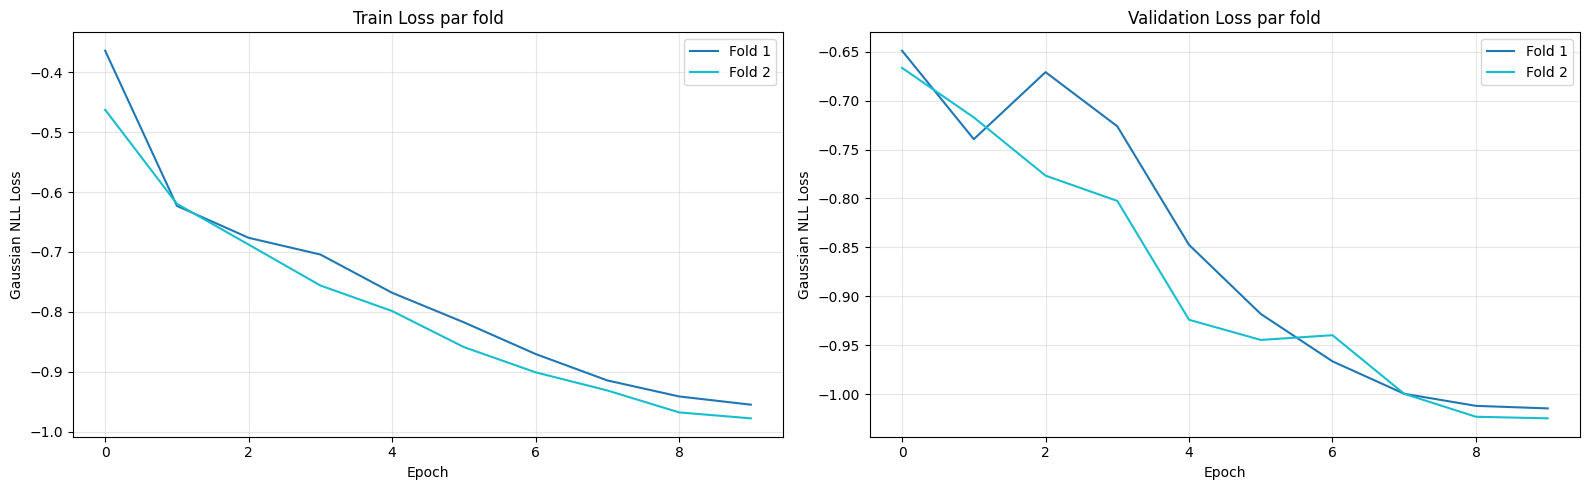

In [58]:
# Courbes d'entraînement par fold
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

colors = plt.cm.tab10(np.linspace(0, 1, N_FOLDS))

for fold in range(N_FOLDS):
    axes[0].plot(all_train_losses[fold], color=colors[fold], linewidth=1.5, label=f'Fold {fold+1}')
    axes[1].plot(all_val_losses[fold], color=colors[fold], linewidth=1.5, label=f'Fold {fold+1}')

axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Gaussian NLL Loss')
axes[0].set_title('Train Loss par fold'); axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Gaussian NLL Loss')
axes[1].set_title('Validation Loss par fold'); axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Évaluation finale sur le test set

On charge les 5 modèles entraînés et on fait la moyenne de leurs prédictions (ensemble). Pour les sigmas, on combine les variances : `sigma_ensemble² = mean(sigma_i²) + mean((mu_i - mu_mean)²)` (loi de la variance totale).

In [59]:
# Évaluation ensemble des 5 folds sur le test set
criterion = nn.GaussianNLLLoss()
all_fold_mu = []
all_fold_sigma = []

for fold in range(N_FOLDS):
    model_path = f'../outputs/best_transformer_02d_fold{fold+1}.pt'
    model = SpikeTransformer(
        nGroups, nChannelsPerGroup,
        embed_dim=EMBED_DIM, nhead=NHEAD, num_layers=NUM_LAYERS,
        dropout=DROPOUT, spike_dropout=SPIKE_DROPOUT, noise_std=NOISE_STD
    ).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE, weights_only=True))
    
    _, fold_mu, fold_sigma, y_test = eval_epoch(model, test_loader, criterion, DEVICE)
    all_fold_mu.append(fold_mu)
    all_fold_sigma.append(fold_sigma)
    
    fold_eucl = np.sqrt((y_test[:, 0] - fold_mu[:, 0])**2 + (y_test[:, 1] - fold_mu[:, 1])**2)
    print(f'Fold {fold+1} sur test: Eucl={fold_eucl.mean():.4f}')

# Ensemble : moyenne des mu
all_fold_mu = np.stack(all_fold_mu)      # (N_FOLDS, n_test, 2)
all_fold_sigma = np.stack(all_fold_sigma)  # (N_FOLDS, n_test, 2)

y_pred = all_fold_mu.mean(axis=0)  # (n_test, 2)

# Sigma ensemble (loi de la variance totale)
mean_var = (all_fold_sigma ** 2).mean(axis=0)  # aleatoric
var_mu = all_fold_mu.var(axis=0)                # epistemic
y_sigma = np.sqrt(mean_var + var_mu)

# Métriques
mse_x = mean_squared_error(y_test[:, 0], y_pred[:, 0])
mse_y = mean_squared_error(y_test[:, 1], y_pred[:, 1])
mae_x = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
mae_y = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
r2_x = r2_score(y_test[:, 0], y_pred[:, 0])
r2_y = r2_score(y_test[:, 1], y_pred[:, 1])
eucl_errors = np.sqrt((y_test[:, 0] - y_pred[:, 0])**2 + (y_test[:, 1] - y_pred[:, 1])**2)

print(f'\n=== Transformer 02d : Spike Dropout {SPIKE_DROPOUT:.0%} + Noise std={NOISE_STD} — Ensemble ({N_FOLDS} folds) ===')
print(f'  MSE  : X={mse_x:.5f}, Y={mse_y:.5f}')
print(f'  MAE  : X={mae_x:.4f}, Y={mae_y:.4f}')
print(f'  R²   : X={r2_x:.4f}, Y={r2_y:.4f}')
print(f'  Eucl : mean={eucl_errors.mean():.4f}, median={np.median(eucl_errors):.4f}, p90={np.percentile(eucl_errors, 90):.4f}')
print(f'\n  Sigma moyen : X={y_sigma[:, 0].mean():.4f}, Y={y_sigma[:, 1].mean():.4f}')
print(f'  Sigma median: X={np.median(y_sigma[:, 0]):.4f}, Y={np.median(y_sigma[:, 1]):.4f}')

Fold 1 sur test: Eucl=0.2773
Fold 2 sur test: Eucl=0.2761

=== Transformer 02d : Spike Dropout 15% + Noise std=0.5 — Ensemble (2 folds) ===
  MSE  : X=0.05597, Y=0.04446
  MAE  : X=0.1840, Y=0.1574
  R²   : X=0.3023, Y=0.5794
  Eucl : mean=0.2705, median=0.2368, p90=0.5123

  Sigma moyen : X=0.2445, Y=0.2025
  Sigma median: X=0.2502, Y=0.2033


## 9. Visualisations

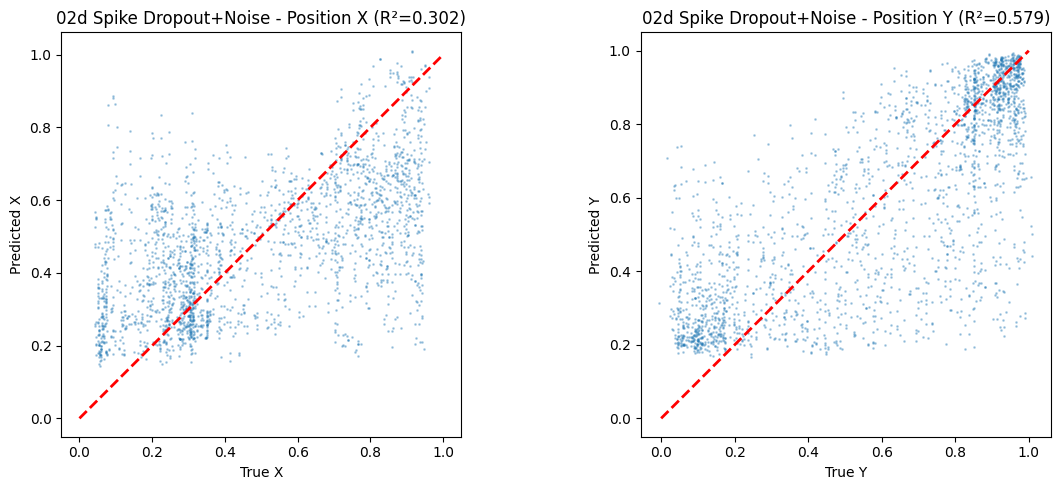

In [60]:
# --- Scatter pred vs true ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(y_test[:, 0], y_pred[:, 0], s=1, alpha=0.3)
axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[0].set_xlabel('True X'); axes[0].set_ylabel('Predicted X')
axes[0].set_title(f'02d Spike Dropout+Noise - Position X (R²={r2_x:.3f})')
axes[0].set_aspect('equal')

axes[1].scatter(y_test[:, 1], y_pred[:, 1], s=1, alpha=0.3)
axes[1].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[1].set_xlabel('True Y'); axes[1].set_ylabel('Predicted Y')
axes[1].set_title(f'02d Spike Dropout+Noise - Position Y (R²={r2_y:.3f})')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

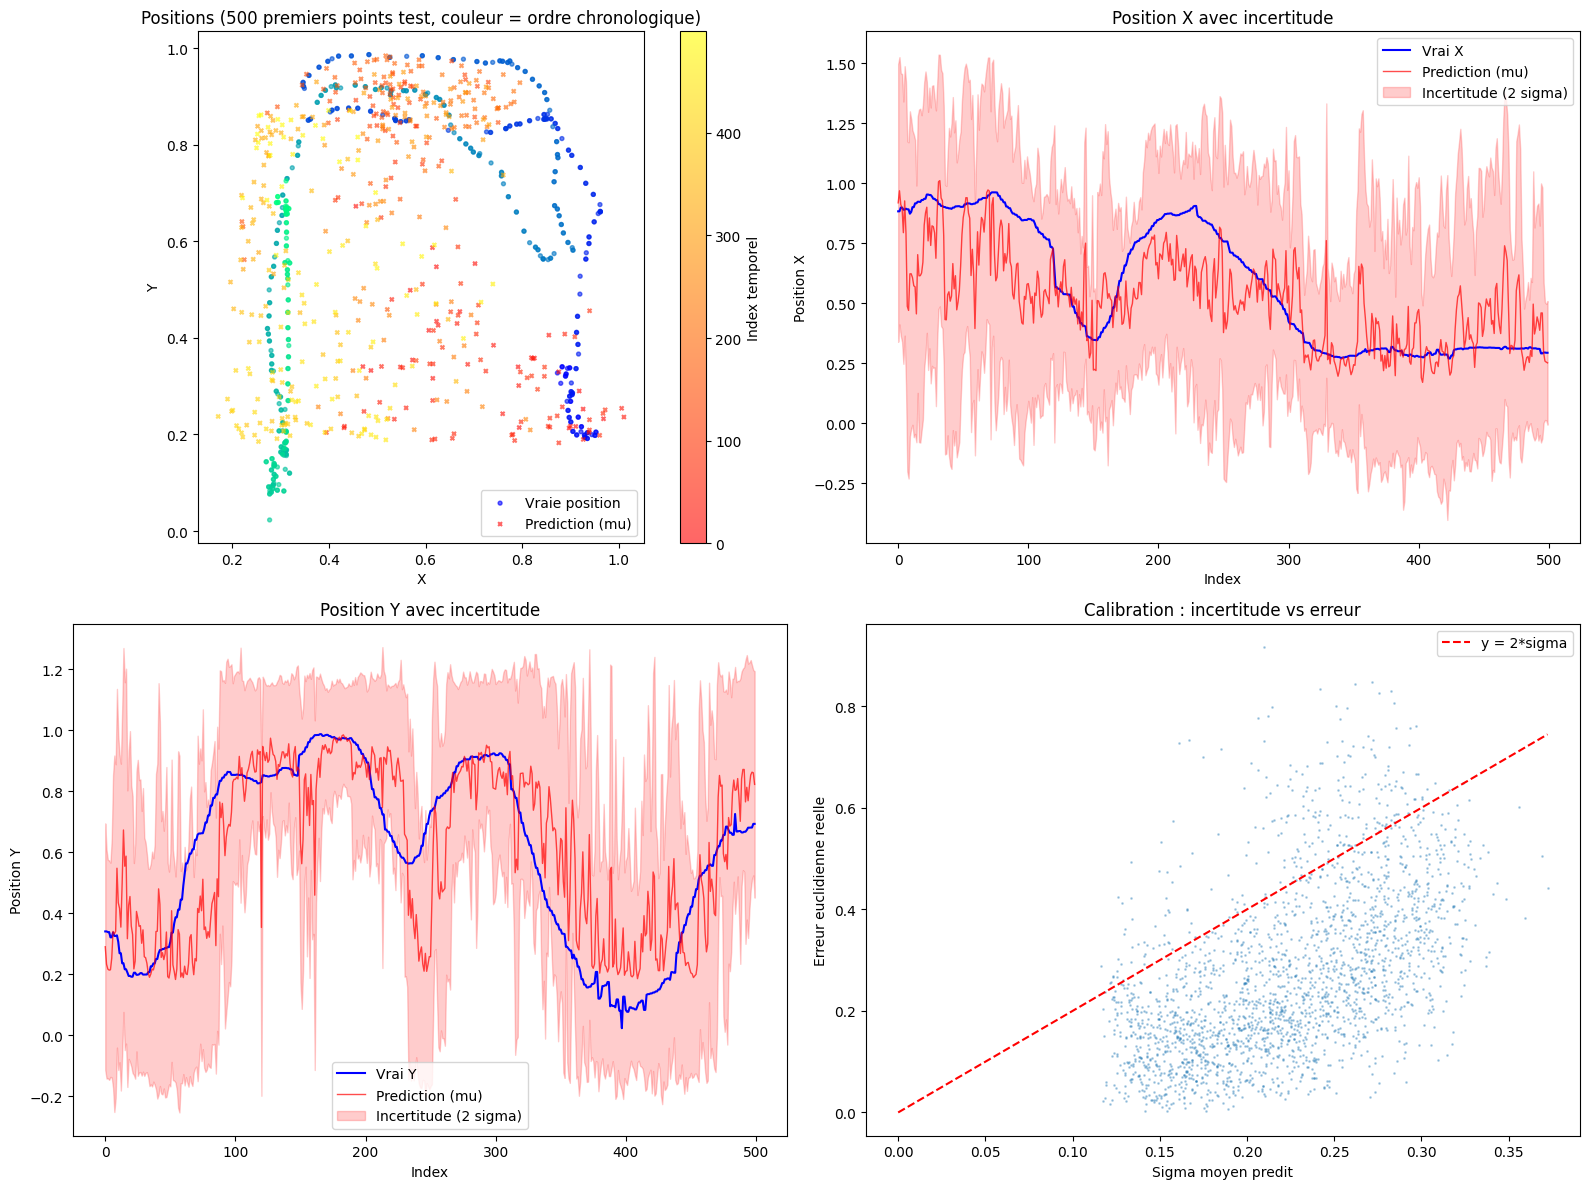

Calibration de l'incertitude :
  Erreur < 1*sigma : 44.5% (attendu ~39% pour gaussienne 2D)
  Erreur < 2*sigma : 89.1% (attendu ~86%)
  Erreur < 3*sigma : 98.7% (attendu ~99%)


In [ ]:
# --- Points prédits vs vrais avec incertitude ---
segment = slice(0, 500)
seg_idx = np.arange(500)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Points 2D colores par ordre chronologique
colors = np.arange(500)
axes[0, 0].scatter(y_test[segment, 0], y_test[segment, 1], c=colors, cmap='winter', s=8, alpha=0.6, label='Vraie position')
sc = axes[0, 0].scatter(y_pred[segment, 0], y_pred[segment, 1], c=colors, cmap='autumn', s=8, alpha=0.6, marker='x', label='Prediction (mu)')
axes[0, 0].set_xlabel('X'); axes[0, 0].set_ylabel('Y')
axes[0, 0].set_title('Positions (500 premiers points test, couleur = ordre chronologique)')
axes[0, 0].legend()
axes[0, 0].set_aspect('equal')
cbar = plt.colorbar(sc, ax=axes[0, 0])
cbar.set_label('Index temporel')

# 2. Position X avec bande d'incertitude (mu +/- 2*sigma)
axes[0, 1].plot(seg_idx, y_test[segment, 0], 'b-', label='Vrai X', linewidth=1.5)
axes[0, 1].plot(seg_idx, y_pred[segment, 0], 'r-', alpha=0.7, label='Prediction (mu)', linewidth=1)
axes[0, 1].fill_between(seg_idx, 
                         y_pred[segment, 0] - 2 * y_sigma[segment, 0],
                         y_pred[segment, 0] + 2 * y_sigma[segment, 0],
                         alpha=0.2, color='red', label='Incertitude (2 sigma)')
axes[0, 1].set_xlabel('Index'); axes[0, 1].set_ylabel('Position X')
axes[0, 1].set_title('Position X avec incertitude')
axes[0, 1].legend()

# 3. Position Y avec bande d'incertitude
axes[1, 0].plot(seg_idx, y_test[segment, 1], 'b-', label='Vrai Y', linewidth=1.5)
axes[1, 0].plot(seg_idx, y_pred[segment, 1], 'r-', alpha=0.7, label='Prediction (mu)', linewidth=1)
axes[1, 0].fill_between(seg_idx,
                         y_pred[segment, 1] - 2 * y_sigma[segment, 1],
                         y_pred[segment, 1] + 2 * y_sigma[segment, 1],
                         alpha=0.2, color='red', label='Incertitude (2 sigma)')
axes[1, 0].set_xlabel('Index'); axes[1, 0].set_ylabel('Position Y')
axes[1, 0].set_title('Position Y avec incertitude')
axes[1, 0].legend()

# 4. Erreur euclidienne vs sigma moyen
sigma_mean = (y_sigma[:, 0] + y_sigma[:, 1]) / 2
axes[1, 1].scatter(sigma_mean, eucl_errors, s=1, alpha=0.3)
axes[1, 1].set_xlabel('Sigma moyen predit'); axes[1, 1].set_ylabel('Erreur euclidienne reelle')
axes[1, 1].set_title('Calibration : incertitude vs erreur')
# Ligne de reference y=2*x (si bien calibre, ~95% des points sous cette ligne)
sigma_range = np.linspace(0, sigma_mean.max(), 100)
axes[1, 1].plot(sigma_range, 2 * sigma_range, 'r--', label='y = 2*sigma', linewidth=1.5)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Calibration : quel % des vraies positions tombe dans l'intervalle predit ?
in_1sigma = np.mean(eucl_errors < sigma_mean)
in_2sigma = np.mean(eucl_errors < 2 * sigma_mean)
in_3sigma = np.mean(eucl_errors < 3 * sigma_mean)
print(f'Calibration de l\'incertitude :')
print(f'  Erreur < 1*sigma : {in_1sigma:.1%} (attendu ~39% pour gaussienne 2D)')
print(f'  Erreur < 2*sigma : {in_2sigma:.1%} (attendu ~86%)')
print(f'  Erreur < 3*sigma : {in_3sigma:.1%} (attendu ~99%)')

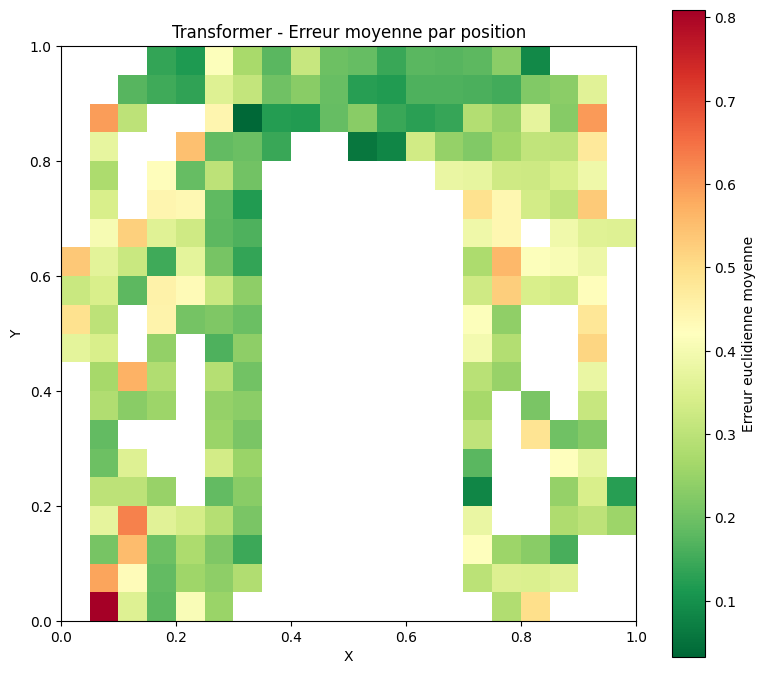

In [62]:
# --- Heatmap des erreurs spatiales ---
fig, ax = plt.subplots(figsize=(8, 7))

nbins = 20
error_map = np.full((nbins, nbins), np.nan)
count_map = np.zeros((nbins, nbins))
x_edges = np.linspace(0, 1, nbins + 1)
y_edges = np.linspace(0, 1, nbins + 1)

for i in range(len(y_test)):
    xi = np.clip(np.searchsorted(x_edges, y_test[i, 0]) - 1, 0, nbins - 1)
    yi = np.clip(np.searchsorted(y_edges, y_test[i, 1]) - 1, 0, nbins - 1)
    if np.isnan(error_map[yi, xi]):
        error_map[yi, xi] = 0
    error_map[yi, xi] += eucl_errors[i]
    count_map[yi, xi] += 1

mean_error_map = np.where(count_map > 0, error_map / count_map, np.nan)

im = ax.imshow(mean_error_map, origin='lower', aspect='equal', cmap='RdYlGn_r', extent=[0, 1, 0, 1])
ax.set_xlabel('X'); ax.set_ylabel('Y')
ax.set_title('Transformer - Erreur moyenne par position')
plt.colorbar(im, ax=ax, label='Erreur euclidienne moyenne')
plt.tight_layout()
plt.show()

## 10. Sauvegarde des prédictions

In [63]:
np.save('../outputs/preds_transformer_02d.npy', y_pred)
np.save('../outputs/sigma_transformer_02d.npy', y_sigma)
np.save('../outputs/y_test_transformer_02d.npy', y_test)
print(f'Predictions ensemble ({N_FOLDS} folds) sauvegardees.')
print(f'  preds_transformer_02d.npy : mu ensemble ({y_pred.shape})')
print(f'  sigma_transformer_02d.npy : sigma ensemble ({y_sigma.shape})')
print(f'  y_test_transformer_02d.npy : targets ({y_test.shape})')

Predictions ensemble (2 folds) sauvegardees.
  preds_transformer_02d.npy : mu ensemble ((2298, 2))
  sigma_transformer_02d.npy : sigma ensemble ((2298, 2))
  y_test_transformer_02d.npy : targets ((2298, 2))


## 11. Analyse de l'incertitude

Avec la sortie probabiliste (Gaussian NLL), le modèle prédit non seulement une position (mu) mais aussi son incertitude (sigma). Cela permet de :
- **Identifier les zones difficiles** : là où sigma est élevé, le modèle "sait qu'il ne sait pas"
- **Pondérer les prédictions** : en aval, on peut donner moins de poids aux prédictions incertaines
- **Détecter les anomalies** : des sigma anormalement élevés peuvent signaler des données hors distribution

Note : le filtre de Kalman et le GRU multi-fenêtres ne sont pas applicables ici car l'objectif est de prédire la position à partir d'une **seule fenêtre isolée**, sans contexte temporel.

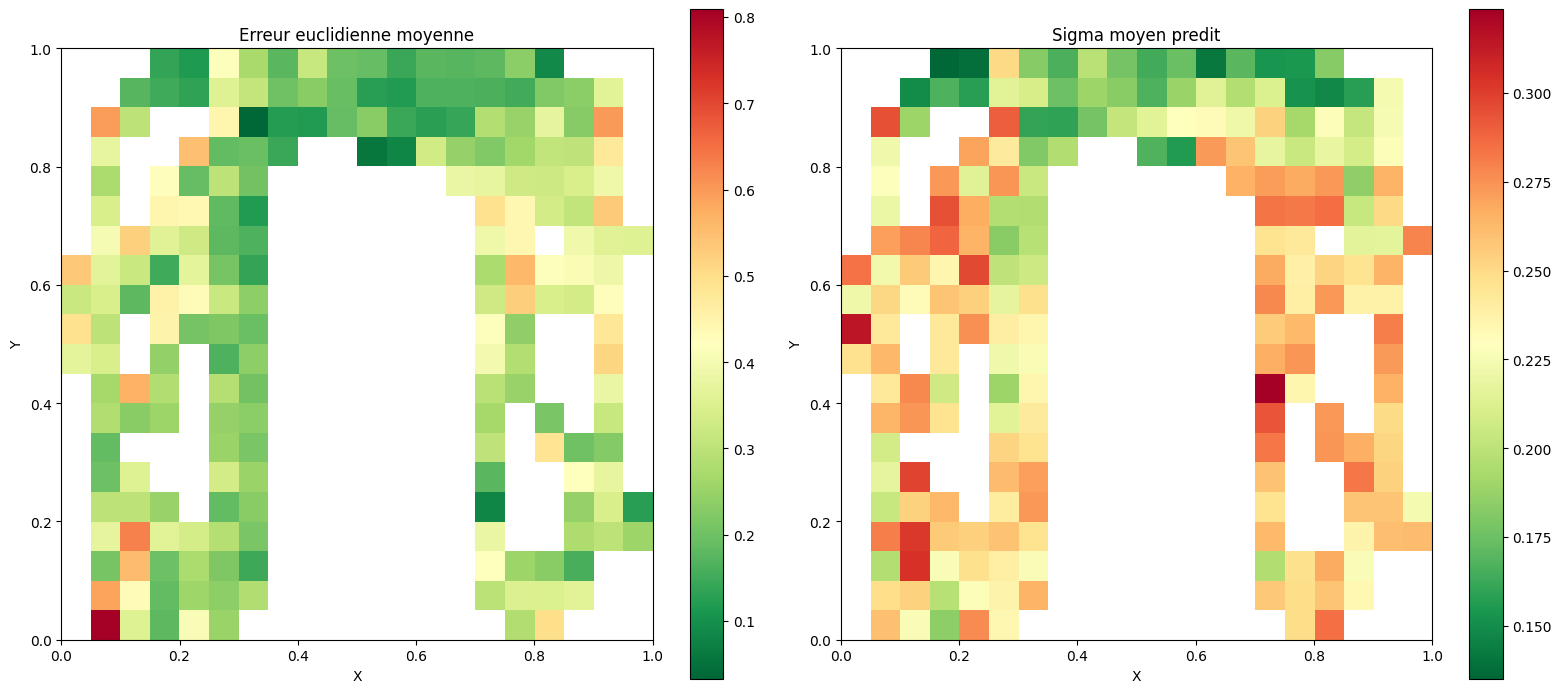

Correlation de Spearman (sigma vs erreur) : 0.572 (p=4.81e-200)
  -> Bonne calibration : le modele sait quand il se trompe


In [64]:
# --- Heatmap de l'incertitude moyenne par position ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

nbins = 20
x_edges = np.linspace(0, 1, nbins + 1)
y_edges = np.linspace(0, 1, nbins + 1)

for ax_idx, (title, values) in enumerate([
    ('Erreur euclidienne moyenne', eucl_errors),
    ('Sigma moyen predit', (y_sigma[:, 0] + y_sigma[:, 1]) / 2)
]):
    val_map = np.full((nbins, nbins), np.nan)
    count_map = np.zeros((nbins, nbins))
    
    for i in range(len(y_test)):
        xi = np.clip(np.searchsorted(x_edges, y_test[i, 0]) - 1, 0, nbins - 1)
        yi = np.clip(np.searchsorted(y_edges, y_test[i, 1]) - 1, 0, nbins - 1)
        if np.isnan(val_map[yi, xi]):
            val_map[yi, xi] = 0
        val_map[yi, xi] += values[i]
        count_map[yi, xi] += 1
    
    mean_map = np.where(count_map > 0, val_map / count_map, np.nan)
    
    im = axes[ax_idx].imshow(mean_map, origin='lower', aspect='equal', 
                              cmap='RdYlGn_r', extent=[0, 1, 0, 1])
    axes[ax_idx].set_xlabel('X'); axes[ax_idx].set_ylabel('Y')
    axes[ax_idx].set_title(title)
    plt.colorbar(im, ax=axes[ax_idx])

plt.tight_layout()
plt.show()

# Correlation entre sigma predit et erreur reelle
from scipy.stats import spearmanr
corr, pval = spearmanr(sigma_mean, eucl_errors)
print(f'Correlation de Spearman (sigma vs erreur) : {corr:.3f} (p={pval:.2e})')
print(f'  -> {"Bonne" if corr > 0.3 else "Faible"} calibration : le modele {"sait" if corr > 0.3 else "ne sait pas bien"} quand il se trompe')

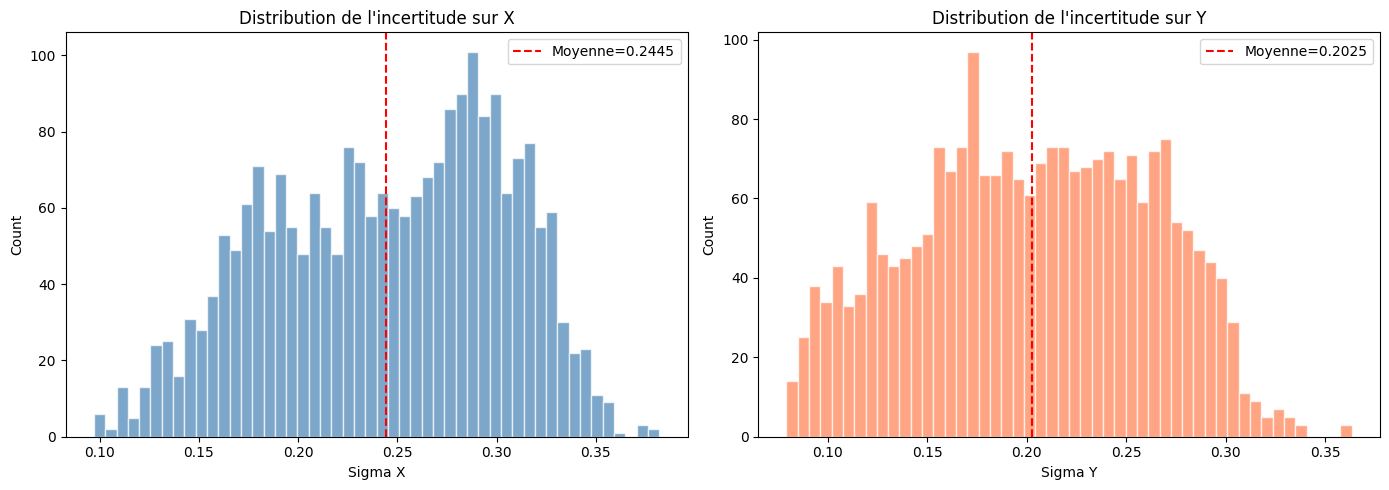

In [65]:
# --- Distribution des sigma predits ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_sigma[:, 0], bins=50, alpha=0.7, color='steelblue', edgecolor='white')
axes[0].axvline(y_sigma[:, 0].mean(), color='red', linestyle='--', label=f'Moyenne={y_sigma[:, 0].mean():.4f}')
axes[0].set_xlabel('Sigma X'); axes[0].set_ylabel('Count')
axes[0].set_title('Distribution de l\'incertitude sur X')
axes[0].legend()

axes[1].hist(y_sigma[:, 1], bins=50, alpha=0.7, color='coral', edgecolor='white')
axes[1].axvline(y_sigma[:, 1].mean(), color='red', linestyle='--', label=f'Moyenne={y_sigma[:, 1].mean():.4f}')
axes[1].set_xlabel('Sigma Y'); axes[1].set_ylabel('Count')
axes[1].set_title('Distribution de l\'incertitude sur Y')
axes[1].legend()

plt.tight_layout()
plt.show()

## 12. Interpretation

### Modifications apportées (02d vs 02)

**1. Spike dropout (15%)** : masquage aléatoire de spikes actifs pendant le training. Force le modèle à exploiter la redondance du population coding.

**2. Gaussian noise (std=0.5)** : bruit additif N(0, 0.5²) sur les waveforms bruts pendant le training. Inspiré de [Frey et al. 2021](https://elifesciences.org/articles/66551) qui utilisent du bruit gaussien sur les inputs pour le décodage spatial hippocampique. Force le CNN encoder à être robuste aux variations de forme de spike (bruit d'enregistrement, drift des électrodes).

Les deux augmentations sont complémentaires :
- Le spike dropout agit au niveau **séquence** (quels spikes sont vus)
- Le gaussian noise agit au niveau **waveform** (comment chaque spike est vu)

### Impact attendu
- **Réduction de l'overfitting** : double régularisation sur les inputs
- **Meilleure généralisation** : robustesse au bruit + à l'absence de spikes
- **Calibration améliorée** : plus de variabilité en training → meilleures estimations d'incertitude